In [63]:
import os
import numpy as np
import torch
import gym
from copy import deepcopy
from datetime import datetime
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple
from tqdm import trange

## Step 1: FX Triplet Environment

In [65]:
@dataclass
class FXTripletConfig:
    T: int = 10                   # horizon (timesteps per episode)
    dt: float = 1/252             # timestep length (years)
    kappa: float = 5.0            # mean reversion speed
    sigma: float = 0.01           # volatility
    theta: float = 0.0            # long-run mean of spread
    seed: int = 0
    discrete_action: bool = True
    n_discrete: int = 125
    min_trade: float = -1.0       # min units per action dim
    max_trade: float = 1.0        # max units per action dim
    terminal_penalty: float = 0.0

class FXTripletEnv(gym.Env):
    def __init__(self, cfg: FXTripletConfig):
        super().__init__()
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)
        self.t = 0
        self.q_eur = 0.0
        self.q_gbp = 0.0
        self.state = None
        # discrete or continuous action space
        if cfg.discrete_action:
            self._action_table = self._build_action_table(cfg.n_discrete)
            self.action_space = gym.spaces.Discrete(len(self._action_table))
        else:
            self._action_table = None
            self.action_space = gym.spaces.Box(
                low=cfg.min_trade, high=cfg.max_trade, shape=(3,), dtype=np.float32
            )
        # observation space: t, Xeurusd, Xgbpusd, q_eur, q_gbp
        obs_high = np.array([np.inf]*5, dtype=np.float32)
        self.observation_space = gym.spaces.Box(-obs_high, obs_high, dtype=np.float32)

    def _build_action_table(self, n: int) -> np.ndarray:
        grid_per_dim = int(round(n ** (1/3)))
        grid = np.linspace(self.cfg.min_trade, self.cfg.max_trade, grid_per_dim)
        combos = np.array(np.meshgrid(grid, grid, grid)).T.reshape(-1,3)
        return combos.astype(np.float32)

    def reset(self):
        self.t = 0
        self.q_eur = 0.0
        self.q_gbp = 0.0
        self.Xeurusd = 1.0
        self.Xgbpusd = 1.3
        self._update_Xeur_gbp()
        self.state = np.array([self.t, self.Xeurusd, self.Xgbpusd, self.q_eur, self.q_gbp], dtype=np.float32)
        return self.state

    def _update_Xeur_gbp(self):
        # enforce no-arbitrage: Xeur_gbp = Xeur_usd / Xgbp_usd
        self.Xeurgbp = self.Xeurusd / self.Xgbpusd

    def step(self, action):
        if self.cfg.discrete_action:
            a = self._action_table[action]
        else:
            a = np.clip(action, self.cfg.min_trade, self.cfg.max_trade)
        # update inventories
        self.q_eur += a[0]
        self.q_gbp += a[1]
        # simulate cointegrated FX rates
        spread = self.Xeurusd - self.Xgbpusd
        spread += self.cfg.kappa * (self.cfg.theta - spread) * self.cfg.dt \
                  + self.cfg.sigma * np.sqrt(self.cfg.dt) * self.rng.normal()
        self.Xeurusd += self.cfg.sigma * np.sqrt(self.cfg.dt) * self.rng.normal()
        self.Xgbpusd = self.Xeurusd - spread
        self._update_Xeur_gbp()
        # reward: simple P&L from inventory times price change
        pnl = (self.q_eur * (self.Xeurusd - self.state[1])) \
            + (self.q_gbp * (self.Xgbpusd - self.state[2]))
        reward = pnl
        self.t += 1
        done = self.t >= self.cfg.T
        if done and self.cfg.terminal_penalty != 0:
            reward -= self.cfg.terminal_penalty * (self.q_eur**2 + self.q_gbp**2)
        self.state = np.array([self.t, self.Xeurusd, self.Xgbpusd, self.q_eur, self.q_gbp], dtype=np.float32)

        info = {
            "q_eur": self.q_eur,
            "q_gbp": self.q_gbp,
            "Xeurusd": self.Xeurusd,
            "Xgbpusd": self.Xgbpusd,
            "Xeurgbp": self.Xeurgbp
        }
        return self.state, reward, done, info

## Step 2: DDQN Baseline

In [67]:
import os
import math
import random
from collections import deque, namedtuple
from typing import List

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from dataclasses import dataclass

@dataclass
class DDQNConfig:
    seed: int = 0
    total_episodes: int = 500
    max_steps_per_episode: int = 10
    batch_size: int = 64
    buffer_size: int = 10000
    gamma: float = 0.999
    lr: float = 1e-4
    target_update_freq: int = 100
    start_training_after: int = 500
    train_frequency: int = 1
    epsilon_start: float = 1.0
    epsilon_final: float = 0.01
    epsilon_decay_steps: int = 20000
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    save_path: str = "./ddqn_checkpoints"
    log_dir: str = "./ddqn_logs"

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity: int, seed: Optional[int] = None):
        self.capacity = int(capacity)
        self.buffer = deque(maxlen=self.capacity)
        self.rng = random.Random(seed)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size: int):
        batch = self.rng.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

class MLPQNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int] = [64,64]):
        super().__init__()
        layers = []
        in_dim = state_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, action_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x: torch.Tensor):
        return self.net(x)

class DDQNAgent:
    def __init__(self, env, cfg: DDQNConfig, hidden_sizes: List[int] = [64,64]):
        self.env = env
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)
        self.device = torch.device(cfg.device)
        self.state_dim = int(np.prod(env.observation_space.shape))
        self.discrete = True
        self.n_actions = int(env.action_space.n)
        self.discrete_action_table = env._action_table
        self.policy_net = MLPQNetwork(self.state_dim, self.n_actions, hidden_sizes).to(self.device)
        self.target_net = MLPQNetwork(self.state_dim, self.n_actions, hidden_sizes).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.replay = ReplayBuffer(cfg.buffer_size, seed=cfg.seed)
        self.total_steps = 0
        self.train_steps = 0
        self.epsilon = cfg.epsilon_start
        self.epsilon_decay = (cfg.epsilon_start - cfg.epsilon_final) / float(max(1, cfg.epsilon_decay_steps))
        os.makedirs(cfg.save_path, exist_ok=True)
        os.makedirs(cfg.log_dir, exist_ok=True)
        self.writer = SummaryWriter(cfg.log_dir)

    def select_action(self, state, eval_mode=False):
        if not eval_mode and self.rng.random() < self.epsilon:
            return int(self.rng.integers(0, self.n_actions))
        state_t = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            qvals = self.policy_net(state_t)
            action = int(torch.argmax(qvals, dim=1).cpu().item())
        return action

    def push_transition(self, state, action, reward, next_state, done):
        self.replay.push(state.astype(np.float32), int(action), float(reward), next_state.astype(np.float32), bool(done))

    def _compute_td_loss(self, batch: Transition) -> torch.Tensor:
        states = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=self.device)
        actions = torch.tensor(batch.action, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.stack(batch.next_state), dtype=torch.float32, device=self.device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=self.device).unsqueeze(1)
        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_policy = self.policy_net(next_states)
            next_actions = torch.argmax(next_q_policy, dim=1, keepdim=True)
            next_q_target = self.target_net(next_states).gather(1, next_actions)
            td_target = rewards + (1.0 - dones) * (self.cfg.gamma * next_q_target)
        loss = nn.MSELoss()(q_values, td_target)
        return loss

    def train_step(self):
        if len(self.replay) < max(self.cfg.batch_size, 1):
            return None
        batch = self.replay.sample(self.cfg.batch_size)
        loss = self._compute_td_loss(batch)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()
        self.train_steps += 1
        if (self.train_steps % self.cfg.target_update_freq) == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return float(loss.item())

    def decay_epsilon(self):
        if self.epsilon > self.cfg.epsilon_final:
            self.epsilon -= self.epsilon_decay
            if self.epsilon < self.cfg.epsilon_final:
                self.epsilon = self.cfg.epsilon_final

    def save(self, tag="latest"):
        path = os.path.join(self.cfg.save_path, f"ddqn_{tag}.pth")
        torch.save({
            "policy_state_dict": self.policy_net.state_dict(),
            "target_state_dict": self.target_net.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "cfg": self.cfg,
        }, path)
        print(f"Saved model to {path}")

    def evaluate(self, n_episodes=10) -> float:
        old_eps = self.epsilon
        self.epsilon = 0.0
        rewards = []
        for ep in range(n_episodes):
            s = self.env.reset()
            ep_r = 0.0
            for _ in range(self.cfg.max_steps_per_episode):
                idx = self.select_action(s, eval_mode=True)
                next_state, r, done, _ = self.env.step(idx)
                s = next_state
                ep_r += r
                if done:
                    break
            rewards.append(ep_r)
        self.epsilon = old_eps
        avg = float(np.mean(rewards))
        print(f"Evaluation over {n_episodes} episodes: avg_reward={avg:.6f}")
        return avg

    def train(self, save_every_episodes=50, eval_every_episodes=50, eval_episodes=10):
        total_steps = 0
        episode_rewards = []
        for episode in range(1, self.cfg.total_episodes + 1):
            state = self.env.reset()
            ep_reward = 0.0
            for step in range(self.cfg.max_steps_per_episode):
                action_idx = self.select_action(state)
                env_action = self.env._action_table[action_idx]
                next_state, reward, done, _ = self.env.step(action_idx)
                self.push_transition(state, action_idx, reward, next_state, done)
                state = next_state
                ep_reward += reward
                total_steps += 1
                if total_steps >= self.cfg.start_training_after:
                    loss = self.train_step()
                self.decay_epsilon()
                if done:
                    break
            episode_rewards.append(ep_reward)
            if episode % 10 == 0:
                print(f"Episode {episode}/{self.cfg.total_episodes}, reward={ep_reward:.4f}")
            if episode % save_every_episodes == 0:
                self.save(tag=f"ep{episode}")
            if episode % eval_every_episodes == 0:
                self.evaluate(n_episodes=eval_episodes)
        self.save(tag="final")
        return episode_rewards

## Instantiate env and run smoke test

In [69]:
cfg_env = FXTripletConfig(T=10, seed=0, discrete_action=True, n_discrete=27)
env = FXTripletEnv(cfg_env)

cfg_ddqn = DDQNConfig(total_episodes=20, max_steps_per_episode=cfg_env.T,
                      buffer_size=2000, start_training_after=20, epsilon_decay_steps=1000)

agent = DDQNAgent(env, cfg_ddqn)
rewards = agent.train(save_every_episodes=10, eval_every_episodes=10, eval_episodes=3)
print("Smoke test completed. Sample rewards:", rewards[:5])

Episode 10/20, reward=-0.0431
Saved model to ./ddqn_checkpoints\ddqn_ep10.pth
Evaluation over 3 episodes: avg_reward=0.042136
Episode 20/20, reward=-0.2293
Saved model to ./ddqn_checkpoints\ddqn_ep20.pth
Evaluation over 3 episodes: avg_reward=0.050276
Saved model to ./ddqn_checkpoints\ddqn_final.pth
Smoke test completed. Sample rewards: [-0.0007598812272111566, -0.06542730824239484, -0.08597486848850022, -0.005957135051971707, 0.0303492950414207]


## Full DDQN training loop using paper hyperparameters

Starting DDQN training (step-based). Device: cpu
Evaluation over 10 episodes: avg_reward=-0.011936
Saved model to ./ddqn_checkpoints_paper\ddqn_best_at_1000.pth
Episode 100, env_steps=1000, ep_reward=-0.118937, recent_avg=-0.024218, eps=0.5050
Evaluation over 10 episodes: avg_reward=-0.017482
Saved model to ./ddqn_checkpoints_paper\ddqn_step_2000.pth
Episode 200, env_steps=2000, ep_reward=-0.012220, recent_avg=-0.030326, eps=0.0100
Evaluation over 10 episodes: avg_reward=0.233427
Saved model to ./ddqn_checkpoints_paper\ddqn_best_at_3000.pth
Episode 300, env_steps=3000, ep_reward=0.297949, recent_avg=-0.016168, eps=0.0100
Evaluation over 10 episodes: avg_reward=0.052607
Saved model to ./ddqn_checkpoints_paper\ddqn_step_4000.pth
Episode 400, env_steps=4000, ep_reward=0.012392, recent_avg=0.050691, eps=0.0100
Evaluation over 10 episodes: avg_reward=0.237074
Saved model to ./ddqn_checkpoints_paper\ddqn_best_at_5000.pth
Episode 500, env_steps=5000, ep_reward=0.289680, recent_avg=0.156820, e

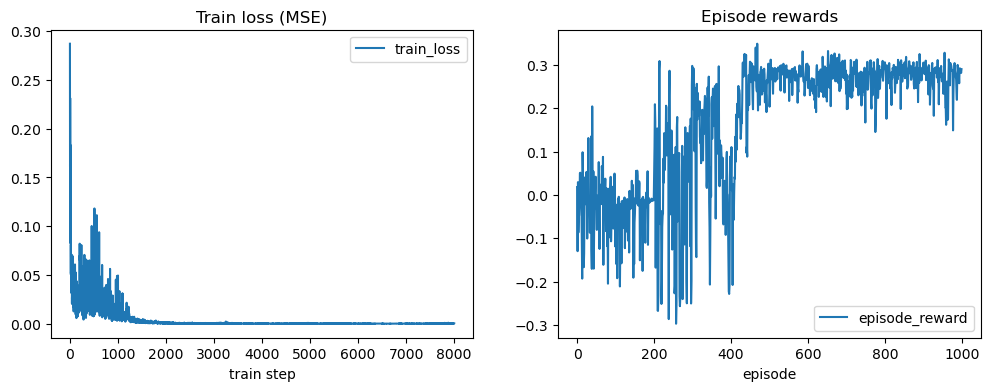

In [71]:
env_cfg = FXTripletConfig(
    T=10,
    seed=42,
    # important model params set to paper values
)
# set paper-specific parameters on the env config object if dataclass supports them
env_cfg.xbar_eusd = 1.1
env_cfg.xbar_gbusd = 1.3
env_cfg.kappa_e = 0.5
env_cfg.kappa_g = 0.5
env_cfg.eta_g_on_e = -0.3
env_cfg.eta_e_on_g = -0.3
env_cfg.sigma = 0.01
env_cfg.min_trade = -1.0
env_cfg.max_trade = 1.0
env_cfg.phi_eusd = 0.001
env_cfg.phi_gbusd = 0.001
env_cfg.phi_eurgbp = 0.001
env_cfg.alpha_eur = 1.0
env_cfg.alpha_gbp = 1.0

# instantiate environment with discrete actions for DDQN
env = FXTripletEnv(env_cfg)  # uses env._action_table if discrete

# DDQN training config (paper-like)
cfg = DDQNConfig(
    seed=42,
    total_episodes=100,           # not used directly; loop by env steps below
    max_steps_per_episode=env_cfg.T,  # T=10
    batch_size=32,
    buffer_size=10000,
    gamma=0.999,
    lr=1e-3,
    target_update_freq=100,           # M = 100 gradient steps
    start_training_after=2000,        # fill buffer with some experiences first
    train_frequency=1,
    epsilon_start=1.0,
    epsilon_final=0.01,
    epsilon_decay_steps=2000,         # fast decay
    device="cuda" if torch.cuda.is_available() else "cpu",
    save_path="./ddqn_checkpoints_paper",
    log_dir=f"./ddqn_logs_paper/{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

os.makedirs(cfg.save_path, exist_ok=True)
os.makedirs(cfg.log_dir, exist_ok=True)

# instantiate agent
agent = DDQNAgent(env, cfg, hidden_sizes=[64,64])

# step-based training loop (stop after target_env_steps)
target_env_steps = 10_000    # paper-level learning steps (adjustable)
best_eval_reward = -np.inf
best_path = None
eval_every = 1_000           # evaluate every N env steps
eval_episodes = 10           # evaluate over 100 episodes
save_every = 2_000           # checkpoint freq

env_steps = 0
episode = 0
train_losses = []
episode_rewards = []
print("Starting DDQN training (step-based). Device:", agent.device)

while env_steps < target_env_steps:
    episode += 1
    state = env.reset()
    ep_reward = 0.0
    for step_in_ep in range(cfg.max_steps_per_episode):
        action_idx = agent.select_action(state, eval_mode=False)
        # pass index directly to env since env is Discrete
        next_state, reward, done, info = env.step(int(action_idx))
        agent.push_transition(state, action_idx, reward, next_state, done)
        state = next_state
        ep_reward += reward
        env_steps += 1

        # training step(s) (train every env step after warmup)
        if env_steps >= cfg.start_training_after and (env_steps % cfg.train_frequency == 0):
            loss = agent.train_step()
            if loss is not None:
                train_losses.append(loss)
                agent.writer.add_scalar("train/loss", loss, env_steps)

        agent.decay_epsilon()

        # periodic evaluation
        if (env_steps % eval_every) == 0:
            eval_avg = agent.evaluate(n_episodes=eval_episodes)
            agent.writer.add_scalar("eval/avg_reward", eval_avg, env_steps)
            # save model if better
            if eval_avg > best_eval_reward:
                best_eval_reward = eval_avg
                agent.save(tag=f"best_at_{env_steps}")
        # periodic checkpoint
        if (env_steps % save_every) == 0:
            agent.save(tag=f"step_{env_steps}")

        if env_steps >= target_env_steps:
            break
        if done:
            break

    episode_rewards.append(ep_reward)
    agent.writer.add_scalar("episode/reward", ep_reward, episode)
    # print progress occasionally
    if episode % 100 == 0:
        recent = np.mean(episode_rewards[-200:]) if len(episode_rewards) >= 1 else ep_reward
        print(f"Episode {episode}, env_steps={env_steps}, ep_reward={ep_reward:.6f}, recent_avg={recent:.6f}, eps={agent.epsilon:.4f}")

# final save
agent.save(tag="final")
print("Training finished. env_steps=", env_steps)

# Save training traces for later plotting
np.savez(os.path.join(cfg.save_path, "train_traces.npz"),
         train_losses=np.array(train_losses),
         episode_rewards=np.array(episode_rewards))

# optional quick plot of loss and rewards (local)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train_loss")
plt.title("Train loss (MSE)")
plt.xlabel("train step")
plt.legend()
plt.subplot(1,2,2)
plt.plot(episode_rewards, label="episode_reward")
plt.title("Episode rewards")
plt.xlabel("episode")
plt.legend()
plt.show()

## Evaluation: P&L histogram and inventory quantiles

100%|██████████| 2000/2000 [00:08<00:00, 247.27it/s]


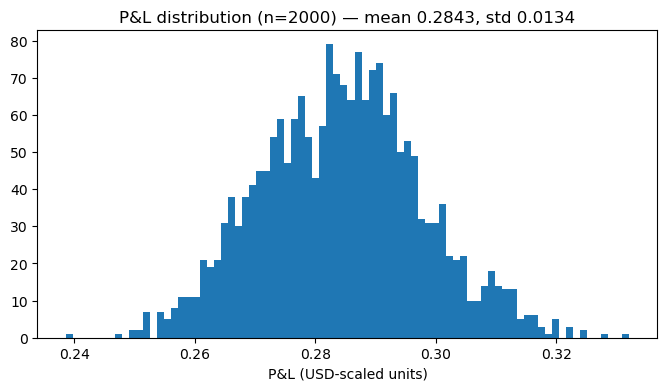

In [73]:
n_sim = 2000    # increase to 10000 for paper-level stats if you have compute
T = env.cfg.T

pnl_list = []
qe_paths = np.zeros((n_sim, T+1))
qg_paths = np.zeros((n_sim, T+1))

for s in trange(n_sim):
    obs = env.reset()
    qe_paths[s,0] = env.q_eur
    qg_paths[s,0] = env.q_gbp
    total_pnl = 0.0
    for t in range(T):
        # greedy eval
        action_idx = agent.select_action(obs, eval_mode=True)
        obs, r, done, info = env.step(int(action_idx))
        total_pnl += r
        qe_paths[s,t+1] = info["q_eur"]
        qg_paths[s,t+1] = info["q_gbp"]
        if done:
            break
    pnl_list.append(total_pnl)

pnl_arr = np.array(pnl_list)

# P&L histogram
plt.figure(figsize=(8,4))
plt.hist(pnl_arr, bins=80)
plt.title(f"P&L distribution (n={n_sim}) — mean {pnl_arr.mean():.4f}, std {pnl_arr.std():.4f}")
plt.xlabel("P&L (USD-scaled units)")
plt.show()

# inventory quantiles (10%,50%,90%)
qe_qs = np.percentile(qe_paths, [10,50,90], axis=0)
qg_qs = np.percentile(qg_paths, [10,50,90], axis=0)

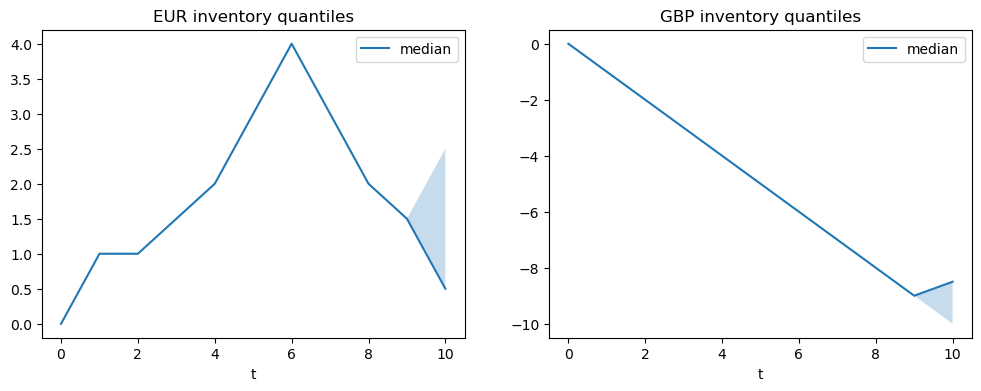

In [74]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.fill_between(range(T+1), qe_qs[0], qe_qs[2], alpha=0.25)
plt.plot(range(T+1), qe_qs[1], label="median")
plt.title("EUR inventory quantiles")
plt.xlabel("t")
plt.legend()

plt.subplot(1,2,2)
plt.fill_between(range(T+1), qg_qs[0], qg_qs[2], alpha=0.25)
plt.plot(range(T+1), qg_qs[1], label="median")
plt.title("GBP inventory quantiles")
plt.xlabel("t")
plt.legend()
plt.show()